<a href="https://colab.research.google.com/github/Emmnmm/sta365hw10/blob/main/Copy_of_HW10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1
define : <br>
- Gaussian Processes (GPs) and stochastic processes generally <br>
- Variational inference using the Evidence Lower Bound (ELBO) <br>

A Stochastic process is a collection of random variables indexed by time or space, representing a system that evolves under uncertainty. Stochastic processes are widely used as mathematical models for systems and phenomena that appear to vary randomly, such as stock prices, weather patterns, and population growth. <br>
The Gaussian Processes (GPs) is a stochastic process where every finite collection of those random variables will follow a multivariate normal distribution, which makes GPs very flexible for modeling complex, non-linear relationships. The key properties of GPs are that it is defined by a mean function and a covariance (kernel) function. The kernel function determines how points influence each other, allowing GPs to model smooth, periodic, or non-stationary functions. <br>
We use Variational Inference (VI) because, in Bayesian inference, the posterior distribution is often too complex to compute directly. As our marginal likelihood p(x) often has no closed-form solution or
requires integrating over all possible parameter values which is impractical in high-dimensional spaces.<br>
Variational inference is a method that uses optimization to find a simpler distribution that is close to the desired posterior to approximate it. The simpler distribution which is also defined as q(θ), is usually found by minimizing its KL divergence which can also be interpreted as minimizing the relative entropy between the two distributions. However, the KL divergence is hard to compute as it requires evaluating the true posterior distribution. This is why the alternative method of maximizing the ELBO is preferred. As the Evidence Lower Bound (ELBO), is a more tractable objective function that indirectly minimizes KL divergence, and maximizing it allows for a good posterior approximation while avoiding computing p(X).<br>

# Q2

/usr/local/lib/python3.11/dist-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


Output()

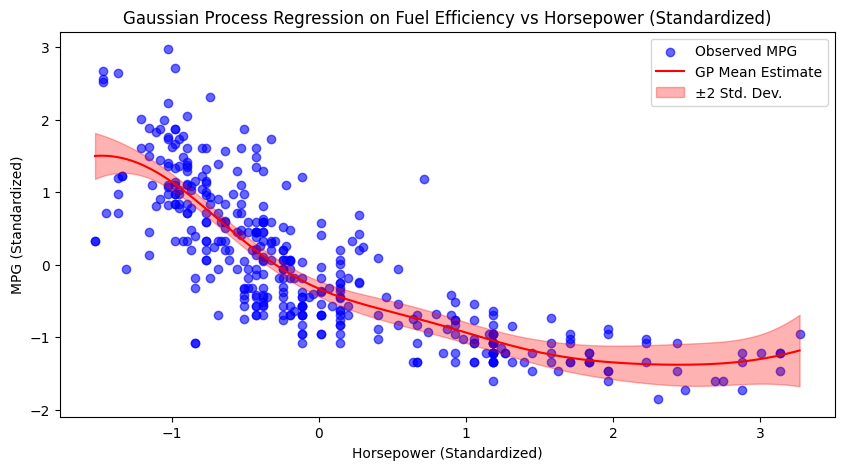

In [ ]:
import pymc as pm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = sns.load_dataset("mpg").dropna()  # Drop missing values

# Define features
X = df["horsepower"].values.reshape(-1, 1)  # Horsepower as input
y = df["mpg"].values  # MPG as target

# Standardize both X and y
X = (X - np.mean(X)) / np.std(X)
y = (y - np.mean(y)) / np.std(y)

# Define Gaussian Process Model
with pm.Model() as gp_model:
    mean_func = pm.gp.mean.Constant(c=0)  # Constant mean function
    kernel = pm.gp.cov.ExpQuad(1, ls=1.0)  # Exponential Quadratic Kernel

    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=kernel)
    sigma = pm.HalfNormal("sigma", 1.0)  # Observation noise

    y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=sigma)

    trace = pm.sample(1000, return_inferencedata=True, target_accept=0.9)

# Make predictions over new horsepower values
X_new = np.linspace(X.min(), X.max(), 200)[:, None]
with gp_model:
    mu, var = gp.predict(X_new, point=trace.posterior.mean(dim=["chain", "draw"]), diag=True)
    sd = np.sqrt(var)

# Plot results on standardized scale
plt.figure(figsize=(10, 5))
plt.scatter(X, y, label="Observed MPG", alpha=0.6, color="blue")  # Original observations
plt.plot(X_new, mu, label="GP Mean Estimate", color="red")  # GP predictions
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, alpha=0.3, color="red", label="±2 Std. Dev.")
plt.title("Gaussian Process Regression on Fuel Efficiency vs Horsepower (Standardized)")
plt.xlabel("Horsepower (Standardized)")
plt.ylabel("MPG (Standardized)")
plt.legend()
plt.show()


- Using the MPG dataset from seaborn with X as horsepower and Y as miles per gallon (mpg) <br>
- predicting the MPG using the Gaussian Process model for a given horsepower value <br>

# Q3

In [4]:
import arviz as az

Output()

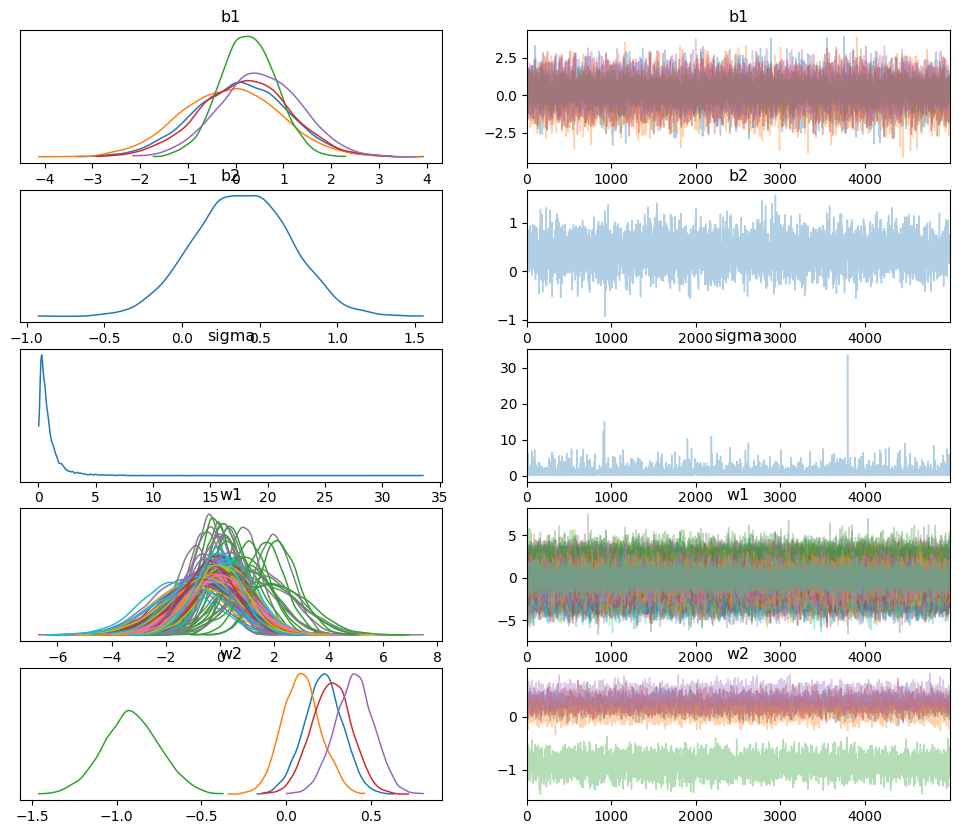

In [7]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pytensor.tensor as pt

# Load Breast Cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Standardize the data
X = StandardScaler().fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


n_hidden = 5
n_features = X_train.shape[1]

with pm.Model() as bnn_vi:
    # Define priors for weights and biases
    w1 = pm.Laplace("w1", mu=0, b=1, shape=(n_features, n_hidden))

    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(n_hidden,))

    w2 = pm.Normal("w2", mu=0, sigma=1, shape=(n_hidden,))
    b2 = pm.Normal("b2", mu=0, sigma=1)

    # Define the hidden layer and output layer
    hidden = pt.maximum(0, pt.dot(X_train, w1) + b1)
    mu = pt.dot(hidden, w2) + b2

    # Define the likelihood with the normal distribution for y_obs
    sigma = pm.HalfNormal("sigma", 1.0)
    y_obs = pm.Bernoulli("y_obs", p=pm.math.sigmoid(mu), observed=y_train)

    # Fit the model using ADVI
    approx = pm.fit(method="advi", n=30000)

# Plot the approximation
trace = approx.sample(draws=5000)
az.plot_trace(trace)
plt.show()


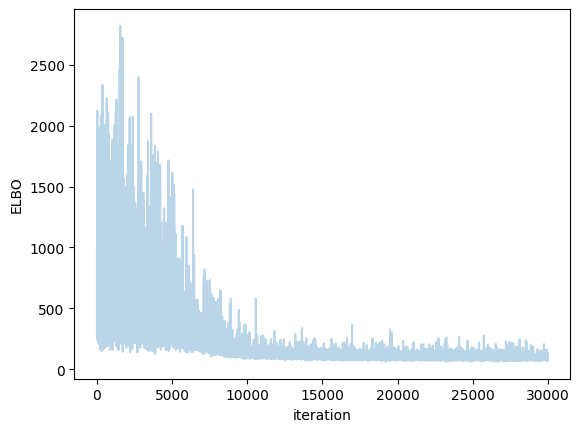

In [8]:
plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("iteration");